**Import Essential Packages**

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Training, Testing, Validation sets**

In [20]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# 自定義 Dataset
class XRD_Dataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name, label = self.file_list[idx]

        # 將 .cif 檔名更改為 .npz
        file_name = file_name.replace('.cif', '_convolved.npz')

        file_path = os.path.join(self.data_dir, file_name)
        data = np.load(file_path)
        x = np.stack((data['x_fine'], data['y_convolved']), axis=1).astype(np.float32)
        # Map string label to integer index
        label = label_map[label]
        return x, label

# 讀取 csv 文件
csv_path = "/content/drive/MyDrive/xrd_training/structure_info.csv"  # 替換為實際 csv 文件路徑
# !unzip /content/drive/MyDrive/xrd_training/output_data.zip
data_dir = "/content/output_data"  # 包含 .npz 文件的目錄
df = pd.read_csv(csv_path)



In [21]:
# 分割數據集

split_info = {
    "tetragonal": (3000, 3000, 300),
    "orthorhombic": (5000, 5000, 500),
    "trigonal": (1000, 1000, 300),
    "cubic": (5000, 5000, 500),
    "triclinic": (1000, 1000, 300),
    "monoclinic": (5000, 5000, 500),
    "hexagonal": (100, 100, 5)
}

train_list, test_list, val_list = [], [], []

for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # 分割成訓練、測試、驗證集
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

# 創建 DataLoader
batch_size = 32

train_dataset = XRD_Dataset(train_list, data_dir)
test_dataset = XRD_Dataset(test_list, data_dir)
val_dataset = XRD_Dataset(val_list, data_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("數據加載完成：")
print(f"訓練集樣本數: {len(train_dataset)}")
print(f"測試集樣本數: {len(test_dataset)}")
print(f"驗證集樣本數: {len(val_dataset)}")



數據加載完成：
訓練集樣本數: 20100
測試集樣本數: 20100
驗證集樣本數: 2405


In [6]:
print(f"Number of batches in train_loader: {len(train_loader)}")

Number of batches in train_loader: 629


In [22]:
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break  # Only for verification

Inputs shape: torch.Size([32, 8500, 2]), Labels shape: torch.Size([32])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


**Define CNN+LSTM Model**

In [9]:
import torch
import torch.nn as nn

class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiLSTM, self).__init__()
        # 1D CNN Layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout_cnn = nn.Dropout(0.3)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.3)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 2, 128)  # 64 * 2: BiLSTM 輸出雙向拼接
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x):
        # CNN Layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout_cnn(x)

        # LSTM expects input of shape [batch, seq_len, feature]
        x = x.permute(0, 2, 1)  # [batch, channels, seq_len] -> [batch, seq_len, channels]

        # BiLSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最後一個時間步的輸出 (也可嘗試全局平均池化)

        # Fully Connected Layers
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


**Training**

In [ ]:
# 定義類別數量（如晶系數量）
num_classes = 7

# 初始化模型
model = CNN_BiLSTM(num_classes=num_classes).to(device)
print(model)

# 定義損失函數與優化器
criterion = nn.CrossEntropyLoss()  # 用於分類問題
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 訓練範例
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        iterator = 1

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, channels]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iterator += 1
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


CNN_BiLSTM(
  (conv1): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_cnn): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (dropout_fc): Dropout(p=0.3, inplace=False)
)


In [12]:
epochs = 40
# 開始訓練
train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)

串流輸出內容已截斷至最後 5000 行。
Loss of 41 = 1.6927087306976318
Loss of 42 = 1.565144658088684
Loss of 43 = 1.71205735206604
Loss of 44 = 1.9199029207229614
Loss of 45 = 1.7449910640716553
Loss of 46 = 1.6972256898880005
Loss of 47 = 1.5394713878631592
Loss of 48 = 1.6559678316116333
Loss of 49 = 1.5264232158660889
Loss of 50 = 1.6620523929595947
Loss of 51 = 1.5313745737075806
Loss of 52 = 1.7616995573043823
Loss of 53 = 1.6809990406036377
Loss of 54 = 1.61868155002594
Loss of 55 = 1.6572461128234863
Loss of 56 = 1.7283344268798828
Loss of 57 = 1.5707453489303589
Loss of 58 = 1.5143039226531982
Loss of 59 = 1.6676554679870605
Loss of 60 = 1.5656404495239258
Loss of 61 = 1.6106013059616089
Loss of 62 = 1.5085746049880981
Loss of 63 = 1.6357669830322266
Loss of 64 = 1.6462109088897705
Loss of 65 = 1.6604739427566528
Loss of 66 = 1.542677879333496
Loss of 67 = 1.750553846359253
Loss of 68 = 1.6510696411132812
Loss of 69 = 1.8106869459152222
Loss of 70 = 1.7394593954086304
Loss of 71 = 1.56473255157

In [13]:
torch.save(model, "/content/drive/MyDrive/xrd_training/CNNLSTM_epoch40.pt")

**Evaluation**

In [11]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # [batch_size, seq_len, channels]

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


In [12]:
model = torch.load("/content/drive/MyDrive/xrd_training/CNNLSTM_epoch40.pt")

<ipython-input-12-5923ea7198dd>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/xrd_training/CNNLSTM_epoch40.pt")


In [13]:
import os
import numpy as np

# Assuming 'test_loader.dataset.file_list' contains [(file_name, label), ...]
missing_files = []

# Iterate through the file list in the dataset
for file_name, _ in test_loader.dataset.file_list:
    # Convert .cif to .npz as per your _getitem_ logic
    file_name = file_name.replace('.cif', '_convolved.npz')
    file_path = os.path.join(test_loader.dataset.data_dir, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        missing_files.append(file_path)

# Report missing files
if missing_files:
    print(f"Missing files ({len(missing_files)}):")
    for missing_file in missing_files:
        print(missing_file)
else:
    print("No missing files in test_loader!")

Missing files (4):
/content/output_data/1550918_convolved.npz
/content/output_data/2104375_convolved.npz
/content/output_data/2104374_convolved.npz
/content/output_data/1552091_convolved.npz


In [14]:
import os
import random
import shutil

# 指定來源與目標資料夾
folder = "/content/output_data"  # 替換為實際資料夾路徑

# 要重新命名的檔案名稱
new_names = [
    "1550918_convolved.npz",
    "2104375_convolved.npz",
    "2104374_convolved.npz",
    "1552091_convolved.npz"
]

# 從資料夾中取得所有檔案
files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

# 確保檔案足夠
if len(files) < len(new_names):
    raise ValueError(f"資料夾中檔案不足，需至少 {len(new_names)} 個檔案，但僅找到 {len(files)} 個。")

# 隨機選擇檔案
selected_files = random.sample(files, len(new_names))

# 複製並重新命名檔案
for src_file, new_name in zip(selected_files, new_names):
    src_path = os.path.join(folder, src_file)
    target_path = os.path.join(folder, new_name)
    shutil.copy(src_path, target_path)
    print(f"已複製 {src_file} 並命名為 {new_name}")


已複製 1530300_convolved.npz 並命名為 1550918_convolved.npz
已複製 1528167_convolved.npz 並命名為 2104375_convolved.npz
已複製 1010272_convolved.npz 並命名為 2104374_convolved.npz
已複製 9016080_convolved.npz 並命名為 1552091_convolved.npz


In [15]:
evaluate_model(model, test_loader)

Accuracy: 24.88%


24.875621890547265

In [ ]:
# model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.device('cpu'))

<ipython-input-11-c8a8b470f539>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.de

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

def evaluate_and_plot_confusion_matrix(model, data_loader, label_map, sample_percentage=0.5, seed=42):
    """
    Evaluates the model on a random sample of the data and plots a confusion matrix with percentage accuracies.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: A DataLoader providing input data and labels.
    - label_map: A dictionary mapping class names to indices.
    - sample_percentage: The percentage of data to sample randomly for evaluation (default 50%).
    - seed: Random seed for reproducibility (default 42).

    Returns:
    - confusion_matrix_percent: A confusion matrix with percentage accuracies.
    """
    # Ensure GPU usage if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    # Initialize confusion matrix
    num_classes = len(label_map)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Set random seed for reproducibility
    random.seed(seed)

    # Select a random subset of the data_loader (sample_percentage)
    total_samples = len(data_loader.dataset)
    num_samples_to_select = int(total_samples * sample_percentage)
    indices = random.sample(range(total_samples), num_samples_to_select)

    # Create a new DataLoader with the sampled indices
    sampled_data = torch.utils.data.Subset(data_loader.dataset, indices)
    sampled_loader = torch.utils.data.DataLoader(sampled_data, batch_size=data_loader.batch_size, shuffle=False)

    # Evaluate the model on the sampled data
    with torch.no_grad():
        for inputs, labels in sampled_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # (batch_size, 8500, 2) -> (batch_size, 2, 8500)

            # Perform forward pass
            outputs = model(inputs)  # Outputs shape: [batch_size, num_classes]
            _, predicted = torch.max(outputs, 1)

            # Update confusion matrix
            for label, pred in zip(labels, predicted):
                confusion_matrix[label.item(), pred.item()] += 1

    # Calculate percentage accuracies for each row (true class)
    confusion_matrix_percent = np.zeros_like(confusion_matrix, dtype=np.float32)

    for i in range(num_classes):
        total = confusion_matrix[i].sum()
        if total > 0:
            confusion_matrix_percent[i] = 100 * confusion_matrix[i] / total

    # Plot the confusion matrix as a heatmap
    class_names = list(label_map.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title("Confusion Matrix (Percentage Accuracy)", fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.show()

    return confusion_matrix_percent


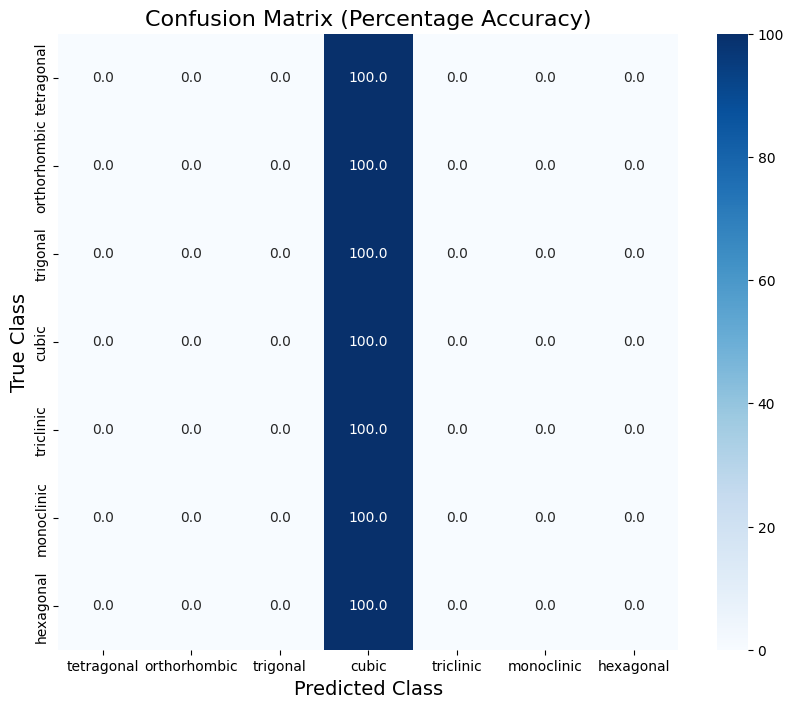

In [19]:
confusion_matrix_percent = evaluate_and_plot_confusion_matrix(model, test_loader, label_map)